# set up environment

### initialize

In [1]:
import os
import glob
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
plt.ion()
from datetime import datetime
from Toolshed import Download, Toolbox, VegetationLine, Plotting, PlottingSeaborn, Transects
import ee
import geopandas as gpd
import geemap
from shapely.geometry import MultiPolygon

ee.Initialize()
ee.Authenticate() # should only need to be run the first time after installation

True

### parameter settings

In [2]:
# The points represent the corners of a bounding box that go around your site
sitename = 'smalltest'

# Date range
dates = ['2014-01-01', '2025-01-01']

# Satellite missions
# Input a list of containing any/all of 'L5', 'L7', 'L8', 'L9', 'S2', 'PSScene4Band'
# L5: 1984-2013; L7: 1999-2017 (SLC error from 2003); L8: 2013-present; S2: 2014-present; L9: 2021-present
sat_list = ['S2']

# Cloud threshold for screening out cloudy imagery (0.5 or 50% recommended)
cloud_thresh = 0.3

# Extract shoreline (wet-dry boundary) as well as veg edge
wetdry = True

# Directory where the data will be stored
filepath = Toolbox.CreateFileStructure(sitename, sat_list)

In [3]:
filepath

'/home/sagemaker-user/COASTGUARD/Data'

In [4]:
import matplotlib
print(matplotlib.get_backend())

widget


# load locations information and Reference Lines

### load reference shoreline AOI on reference shoreline (in library)

In [5]:
# Reference shoreline/veg line shapefile name (should be stored in a folder called referenceLines in Data)
# Line should be ONE CONTINUOUS linestring along the shore, stored as a shapefile in WGS84 coord system
referenceLineShp = sitename + '_ref.shp'
# Maximum amount in metres by which to buffer the reference line for capturing veg edges within
max_dist_ref = 150

In [6]:
# Return AOI from reference line bounding box and save AOI folium map HTML in sitename directory
referenceLinePath = os.path.join(filepath, 'referenceLines', referenceLineShp)
referenceLineDF = gpd.read_file(referenceLinePath)
polygon, point, lonmin, lonmax, latmin, latmax = Toolbox.AOIfromLine(referenceLinePath, max_dist_ref, sitename)

# It's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = Toolbox.smallest_rectangle(polygon)

In [7]:
referenceLinePath

'/home/sagemaker-user/COASTGUARD/Data/referenceLines/smalltest_ref.shp'

In [8]:
# get polygon centroid, coordinates to get tides from
import numpy as np
centroid = np.mean(polygon[0], axis=0)
print(centroid)
# if longitude is negative add 180 (longitudes are from 0 to 360 in fes)
if centroid[0] < 0: centroid[0] += 360

[-66.23066578  45.14371425]


### date range

In [9]:
if len(dates)>2:
    daterange='no'
else:
    daterange='yes'
years = list(Toolbox.daterange(datetime.strptime(dates[0],'%Y-%m-%d'), datetime.strptime(dates[-1],'%Y-%m-%d')))

### Compile Input Settings for Gathering Imagery

In [10]:
inputs = {
    'polygon': polygon,
    'dates': dates,
    'daterange': daterange,
    'sat_list': sat_list,
    'sitename': sitename,
    'filepath': filepath
}

In [11]:
inputs

{'polygon': [[[-66.23802289695303, 45.1415656881299],
   [-66.21963010709617, 45.1415656881299],
   [-66.21963010709617, 45.14693708311553],
   [-66.23802289695303, 45.14693708311553],
   [-66.23802289695303, 45.1415656881299]]],
 'dates': ['2014-01-01', '2025-01-01'],
 'daterange': 'yes',
 'sat_list': ['S2'],
 'sitename': 'smalltest',
 'filepath': '/home/sagemaker-user/COASTGUARD/Data'}

### Image Retrieval and download

In [12]:
inputs = Download.check_images_available(inputs)

Images available between 2014-01-01 and 2025-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:


/home/sagemaker-user/.conda/envs/coastguard/lib/python3.10/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


  S2: 411 images
  Total: 411 images


In [13]:
Sat = Download.RetrieveImages(inputs)
metadata = Download.CollectMetadata(inputs, Sat)

retrieving image metadata...
Metadata already exists and was loaded


# Veg detection

### settings

In [14]:
BasePath = 'Data/' + sitename + '/lines'

if not os.path.isdir(BasePath):
    os.makedirs(BasePath)

projection_epsg, _ = Toolbox.FindUTM(polygon[0][0][1],polygon[0][0][0])

In [15]:
settings = {
    # general parameters:
    'cloud_thresh': cloud_thresh,        # threshold on maximum cloud cover
    'output_epsg': projection_epsg,     # epsg code of spatial reference system desired for the output   
    'wetdry': wetdry,              # extract wet-dry boundary as well as veg
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': True,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 200,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) for buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    # add the inputs defined previously
    'inputs': inputs,
    'projection_epsg': projection_epsg,
    'year_list': years,
}

# Vegetation Line Extraction

##### first time detection: 

In [17]:
referenceLine, ref_epsg = Toolbox.ProcessRefline(referenceLinePath, settings)
settings['reference_shoreline'] = referenceLine
settings['ref_epsg'] = ref_epsg
# Distance to buffer reference line by (this is in metres)
settings['max_dist_ref'] = max_dist_ref

settings['reference_coreg_im'] = None # leave as None if no coregistration is to be performed

Mapping veglines:
Using initial georef: [717129, 10, 0, 5002985, 0, -10]
S2:   0.345 %  
saving COPERNICUS/S2_SR_HARMONIZED/20181213T152629_20181213T152947_T19TGL
 
saving classified COPERNICUS/S2_SR_HARMONIZED/20181213T152629_20181213T152947_T19TGL
 
saving transition zone of COPERNICUS/S2_SR_HARMONIZED/20181213T152629_20181213T152947_T19TGL


AttributeError: 'FigureManager' object has no attribute 'window'

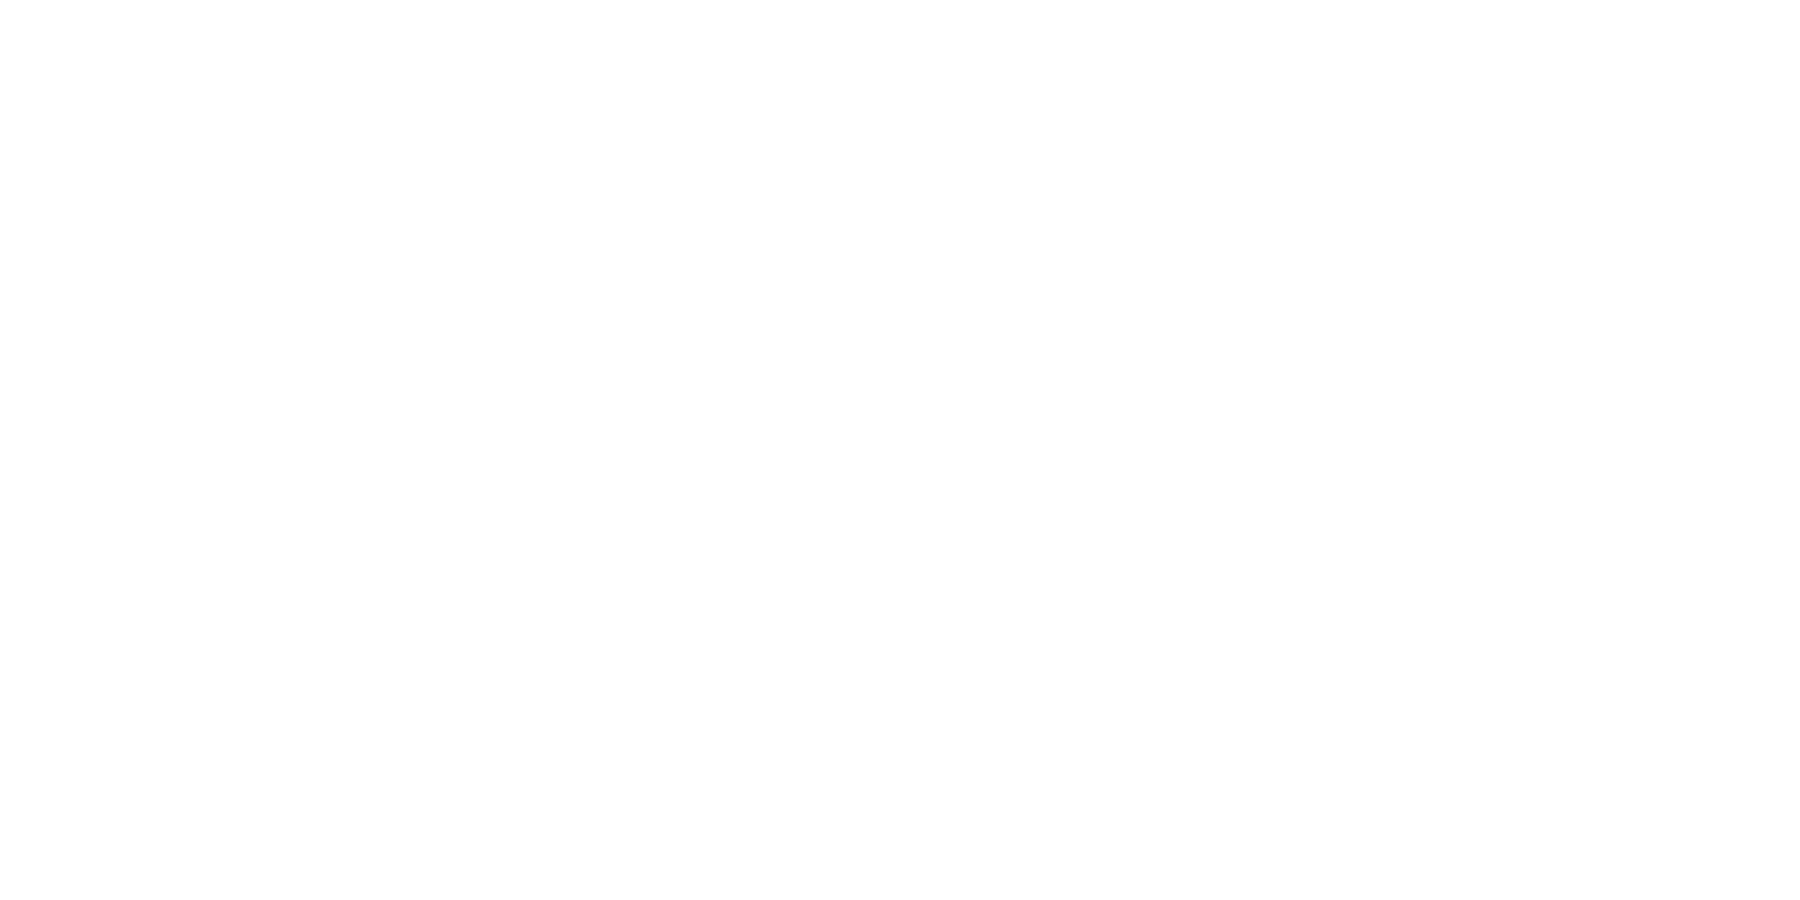

In [18]:
output, output_latlon, output_proj = VegetationLine.extract_veglines(metadata, settings, polygon, dates)

##### second time load in:

In [ ]:
output, output_latlon, output_proj = Toolbox.ReadOutput(inputs)

# Remove Duplicate Lines
# For images taken on the same date by the same satellite, keep only the longest line
output = Toolbox.RemoveDuplicates(output) 

##### save outcome to local shapefile

In [ ]:
# Save output veglines 
Toolbox.SaveConvShapefiles(output, BasePath, sitename, settings['output_epsg'])
# Save output shorelines if they were generated
if settings['wetdry'] == True:
    Toolbox.SaveConvShapefiles_Water(output, BasePath, sitename, settings['output_epsg'])

# Transects detection

#### basics

##### settings

In [ ]:
# settings
SmoothingWindowSize = 21 
NoSmooths = 100
TransectSpacing = 10
DistanceInland = 100
DistanceOffshore = 100

# Provide average beach slope (tanBeta) for site, for calculating corrected beach widths
# Set to 'None' if you want to use CoastSat.slope to calculate per-transect slopes for correcting with
beachslope = None

##### cross-shorelines transects

In [ ]:
VegBasePath = 'Data/' + sitename + '/lines'
VeglineShp = glob.glob(BasePath+'/*veglines.shp')
VeglineGDF = gpd.read_file(VeglineShp[0])
VeglineGDF = VeglineGDF.sort_values(by='dates') # sort GDF by dates to ensure transect intersects occur in chronological order
VeglineGDF = VeglineGDF.reset_index(drop=True) # reset GDF index after date sorting
if settings['wetdry'] == True:
    WaterlineShp = glob.glob(BasePath+'/*waterlines.shp')
    WaterlineGDF = gpd.read_file(WaterlineShp[0])
    WaterlineGDF = WaterlineGDF.sort_values(by='dates') # as above with VeglineGDF date sorting
    WaterlineGDF = WaterlineGDF.reset_index(drop=True)
# Produces Transects for the reference line
TransectSpec =  os.path.join(BasePath, sitename+'_Transects.shp')

# If transects already exist, load them in
if os.path.isfile(TransectSpec[:-3]+'pkl') is False:
    TransectGDF = Transects.ProduceTransects(settings, SmoothingWindowSize, NoSmooths, TransectSpacing, DistanceInland, DistanceOffshore, VegBasePath, referenceLineShp)
else:
    print('Transects already exist and were loaded')
    with open(TransectSpec[:-3]+'pkl', 'rb') as Tfile: 
        TransectGDF = pickle.load(Tfile)
    
# make new transect intersections folder
if os.path.isdir(os.path.join(filepath, sitename, 'intersections')) is False:
    os.mkdir(os.path.join(filepath, sitename, 'intersections'))

##### veg edges intersection along each transect

In [ ]:
if os.path.isfile(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_intersects.pkl')):
    print('Transect Intersect GDF exists and was loaded')
    with open(os.path.join
              (filepath , sitename, 'intersections', sitename + '_transect_intersects.pkl'), 'rb') as f:
        TransectInterGDF = pickle.load(f)
else:
    # Get intersections
    TransectInterGDF = Transects.GetIntersections(BasePath, TransectGDF, VeglineGDF)
    # Save newly intersected transects as shapefile
    TransectInterGDF = Transects.SaveIntersections(TransectInterGDF, VeglineGDF, BasePath, sitename)
    # Repopulate dict with intersection distances along transects normalised to transect midpoints
    TransectInterGDF = Transects.CalculateChanges(TransectInterGDF)
    
    with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_intersects.pkl'), 'wb') as f:
        pickle.dump(TransectInterGDF, f)

##### waterlines intersection along each transect

In [ ]:
if os.path.isfile(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_water_intersects.pkl')):
    print('Transect Intersect + Water GDF exists and was loaded')
    with open(os.path.join
              (filepath , sitename, 'intersections', sitename + '_transect_water_intersects.pkl'), 'rb') as f:
        TransectInterGDFWater = pickle.load(f)
else:        
    if settings['wetdry'] == True:
        TransectInterGDFWater = Transects.GetWaterIntersections(BasePath, TransectGDF, TransectInterGDF, WaterlineGDF, settings, output)  
    
    with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_water_intersects.pkl'), 'wb') as f:
        pickle.dump(TransectInterGDFWater, f)

#### waves and tide included

##### waves intersections

In [ ]:
import traceback

if os.path.isfile(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_wave_intersects.pkl')):
    print('Transect Intersect + Wave GDF exists and was loaded')
    with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_wave_intersects.pkl'), 'rb') as f:
        TransectInterGDFWave = pickle.load(f)
else:
    try:
        TransectInterGDFWave = Transects.WavesIntersect(settings, TransectInterGDF, BasePath, output, lonmin, lonmax, latmin, latmax)

        with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_wave_intersects.pkl'), 'wb') as f:
            pickle.dump(TransectInterGDFWave, f)

        print(f'Wave intersect successfully generated and saved for site: {sitename}')

    except Exception as e:
        print(f'Failed to process wave data for site: {sitename}')
        print('Error message:', str(e))
        traceback.print_exc()
        TransectInterGDFWave = None

##### Additional wave-based WL metrics
This is for comparing shoreline change with vegetation change, and for quantifying the beach width between the two for each image. If you would like to include runup in your waterline corrections, add `TransectInterGDFWave` to `GetWaterIntersections()`:

```TransectInterGDFWater = Transects.GetWaterIntersections(BasePath, TransectGDF, TransectInterGDF, WaterlineGDF, settings, output, TransectInterGDFWave, beachslope)```

If you want to include runup AND calculate slopes using CoastSat.slope (recommended), exclude the `beachslope` variable:

`TransectInterGDFWater = Transects.GetWaterIntersections(BasePath, TransectGDF, TransectInterGDF, WaterlineGDF, settings, output, TransectInterGDFWave)`

In [ ]:
import pandas as pd
from datetime import datetime

# === 1. Load your original tide CSV ===
tide_df = pd.read_csv(r'C:\MPA\tide_data\tide_db\coast_tides_1.csv')

# === 2. Convert the 'dates' column to remove timezone ===
# It will convert to naive datetime (no timezone)
tide_df['dates'] = pd.to_datetime(tide_df['dates']).dt.tz_localize(None)
tide_df = tide_df.rename(columns={'dates': 'date'})

# === 3. Save to correct CoastGuard path ===
date_start = '2015-01-01'
date_end = '2025-01-01'

# Build the output path
save_path = fr'C:\MPA\COASTGUARD\Data\tides\{sitename}_tides_{date_start}_{date_end}.csv'

# Save without index
tide_df.to_csv(save_path, index=False)

print(f"Tide file saved to {save_path}")

In [ ]:
beachslope = None

TransectInterGDFWater = Transects.GetWaterIntersections(BasePath, TransectGDF, TransectInterGDF, WaterlineGDF, settings, output)

In [ ]:
# Check if waterline corrections have been applied
if 'wlcorrdist' not in TransectInterGDFWater.columns:
    # Apply tidal + wave runup correction
    TransectInterGDFWater = Transects.WLCorrections(
        settings, 
        output, 
        TransectInterGDFWater, 
        TransectInterGDFWave,  # <- Add the wave-based intersections here
        # Do NOT pass beachslope — leave it to auto-calculate!
    )     

# Calculate the beach width between Vegetation Line and corrected Water Line
TransectInterGDFWater = Transects.CalcBeachWidth(
    settings, 
    TransectGDF, 
    TransectInterGDFWater
)

# Save corrected Water Line intersections shapefile
TransectInterGDFWater = Transects.SaveWaterIntersections(
    TransectInterGDFWater, 
    WaterlineGDF,  
    BasePath, 
    sitename
)

In [ ]:
# Save intersections as a pickle file
with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_water_intersects.pkl'), 'wb') as f:
    pickle.dump(TransectInterGDFWater, f)

In [ ]:
import scipy
print(scipy.__version__)

##### Transect-Topo Intersections
intersections with topographic data along each transect. This is for comparing veg edge positions with dune slopes

In [ ]:
# EDIT ME: Path to slope raster for extracting slope values
TIF = '/path/to/Slope_Raster.tif'

if os.path.isfile(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_topo_intersects.pkl')):
    print('Transect Intersect + Topo GDF exists and was loaded')
    with open(os.path.join
              (filepath , sitename, 'intersections', sitename + '_transect_topo_intersects.pkl'), 'rb') as f:
        TransectInterGDFTopo = pickle.load(f)
else:
    # Update Transects with Transition Zone widths and slope if available
    TransectInterGDFTopo = Transects.TZIntersect(settings, TransectInterGDF, VeglineGDF, BasePath)
    TransectInterGDFTopo = Transects.SlopeIntersect(settings, TransectInterGDFTopo, VeglineGDF, BasePath, TIF)
    
    with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_topo_intersects.pkl'), 'wb') as f:
        pickle.dump(TransectInterGDFTopo, f)

#### Plotting
Edit the desired Transect IDs to plot timeseries of veg change and beach width change across 

In [ ]:
# Timeseries Plotting

# EDIT ME: Select transect ID to plot
# You can plot subplots within a list of plot IDs, e.g. [[sub1, sub2], plot2]
# You can also comment Line 1 out and uncomment Line 2 to create plots for ALL Transect IDs
# NOTE: If you want to plot ALL transects, it's recommended you switch ShowPlot=False

TransectIDs = [[25,30,35],50,75] # Line 1
# TransectIDs = list(TransectInterGDF['TransectID']) # Line 2

for TransectID in TransectIDs:
    # Plot timeseries of cross-shore veg position
    Plotting.VegTimeseries(sitename, TransectInterGDF, TransectID, Hemisphere='N', ShowPlot=True)
    # If plotting veg and water lines together
    if settings['wetdry']:
        Plotting.VegWaterTimeseries(sitename, TransectInterGDFWater, TransectID, Hemisphere='N', ShowPlot=True)


In [ ]:
# Beach Width Plotting

# Select transect ID to plot
TransectIDs = [[25,30,35],50,75]
for TransectID in TransectIDs:
    # Plot timeseries of cross-shore width between water edge and veg edge 
    Plotting.WidthTimeseries(sitename, TransectInterGDFWater, TransectID, Hemisphere='N')


In [ ]:
# EDIT ME: Path to slope raster for extracting slope values
# TIF = r"C:\MPA\COASTGUARD\TestData\C1\slopes\musquash_slope.tif"  # example path

if os.path.isfile(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_topo_intersects.pkl')):
    print('Transect Intersect + Topo GDF exists and was loaded')
    with open(os.path.join
              (filepath , sitename, 'intersections', sitename + '_transect_topo_intersects.pkl'), 'rb') as f:
        TransectInterGDFTopo = pickle.load(f)
else:
    # Update Transects with Transition Zone widths and slope if available
    TransectInterGDFTopo = Transects.TZIntersect(settings, TransectInterGDF, VeglineGDF, BasePath)
    # TransectInterGDFTopo = Transects.SlopeIntersect(settings, TransectInterGDFTopo, VeglineGDF, BasePath, TIF)
    
    with open(os.path.join(filepath, sitename, 'intersections', sitename + '_transect_topo_intersects.pkl'), 'wb') as f:
        pickle.dump(TransectInterGDFTopo, f)

In [ ]:
# Timeseries Plotting

# EDIT ME: Select transect ID to plot
# You can plot subplots within a list of plot IDs, e.g. [[sub1, sub2], plot2]
# You can also comment Line 1 out and uncomment Line 2 to create plots for ALL Transect IDs
# NOTE: If you want to plot ALL transects, it's recommended you switch ShowPlot=False

TransectIDs = [[25,30,35],50,75] # Line 1
# TransectIDs = list(TransectInterGDF['TransectID']) # Line 2

for TransectID in TransectIDs:
    # Plot timeseries of cross-shore veg position
    Plotting.VegTimeseries(sitename, TransectInterGDF, TransectID, Hemisphere='N', ShowPlot=True)
    # If plotting veg and water lines together
    if settings['wetdry']:
        Plotting.VegWaterTimeseries(sitename, TransectInterGDFWater, TransectID, Hemisphere='N', ShowPlot=True)